# View six examples (Manuscript Figure 4)
Plots six examples (two from each subtype, IPH, SDH, EDH) from a synthetic dataset.

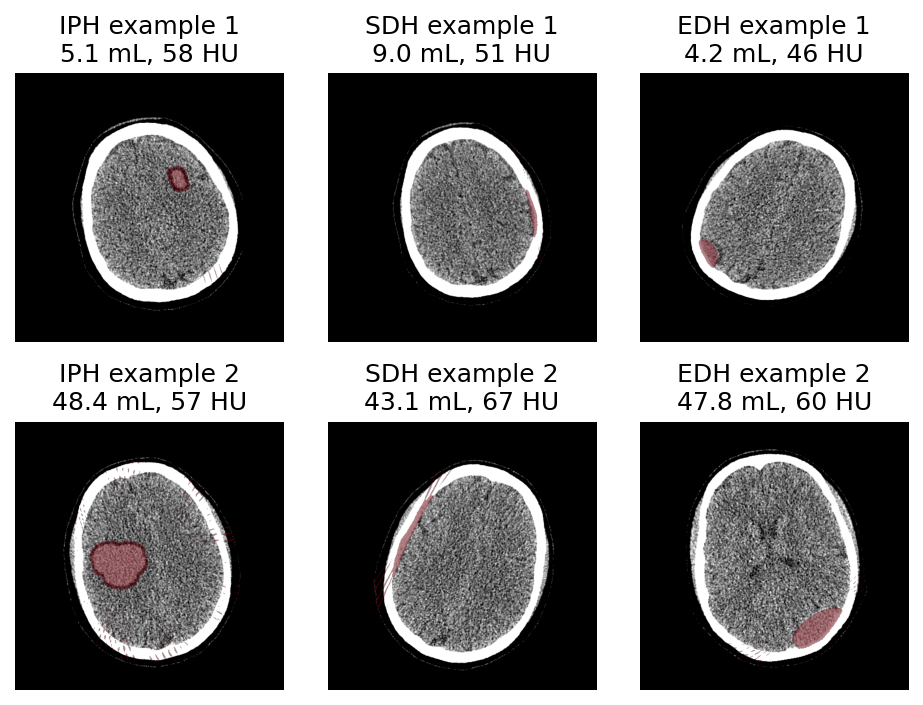

In [3]:
from image_utils import *
from pathlib import Path
import pandas as pd
import numpy as np

from insilicoICH.image_acquisition import read_dicom
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

#from utils import display_settings, browse_studies, study_viewer

study_name = 'mA_280_run1'
base_dir = Path('../datasets') / study_name

metadata = pd.concat([pd.read_csv(o) for o in base_dir.rglob('metadata*.csv')], ignore_index=True).sort_values(by=['name', 'image file']).reset_index(drop=True)
metadata.loc[~metadata.intensity.isna(), 'lesion type'] = metadata[~metadata.intensity.isna()]['lesion type'].apply(lambda x: x.split("['")[-1].split("']")[0])
metadata.loc[~metadata.intensity.isna(), 'intensity'] = metadata[~metadata.intensity.isna()]['intensity'].apply(lambda x: float(x.split('[')[-1].split(']')[0])).astype(int)
metadata['image file']=metadata['image file'].apply(lambda x: base_dir / str(x.split(study_name+'/')[-1]))
metadata.loc[~metadata['mask file'].isna(), 'mask file']=metadata.loc[~metadata['mask file'].isna(), 'mask file'].apply(lambda x: base_dir / str(x.split(study_name+'/')[-1]))
metadata

for n in metadata['name'].unique():
    metadata.loc[metadata['name'] == n, 'slice'] = list(range(len( metadata[metadata['name'] == n])))
metadata['slice'] = metadata['slice'].astype(int)

metadata[~metadata.name.duplicated()]

#from utils import ctshow
window = 'brain'

cases = ['case_065', 'case_032', 'case_062'] # ROW 1: [IPH, SDH, EDH, all small]
cases = cases + ['case_084', 'case_014', 'case_003'] # ROW 2: [IPH, SDH, EDH, larger]

f, axs = plt.subplots(nrows=2, ncols=3, dpi=150, tight_layout=True)
for idx, ax in enumerate(axs.flat):
    case = cases[idx]
    z = metadata[(metadata['name'] == case) & (metadata['lesion volume [mL]']>0)]['center z'].iloc[0].astype(int)
    mask = read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z)]['mask file'].item())
    img = read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z)]['image file'].item())

    age =  metadata[metadata['name'] == case].iloc[z]['age'].astype(int)
    
    lesion_type = metadata[metadata['name'] == case].iloc[z]['lesion type']
    vol =  metadata[metadata['name'] == case]['lesion volume [mL]'].sum()
    intensity = metadata[metadata['name'] == case].iloc[z]['intensity']
    
    new_mask = np.ma.masked_where(mask == 0, mask)
    ax.imshow(img, cmap='gray', vmin=0, vmax=80)
    ax.imshow(new_mask, cmap='Reds_r', alpha=0.5)

    if lesion_type == 'round':
        lesion_type = 'IPH'
    if lesion_type == 'subdural':
        lesion_type = 'SDH'
    if lesion_type == 'epidural':
        lesion_type = 'EDH'
    if idx < 3:
        ax.set_title(f'{lesion_type} example 1\n{vol:2.1f} mL, {intensity} HU')
    else:
        ax.set_title(f'{lesion_type} example 2\n{vol:2.1f} mL, {intensity} HU')
    ax.axis("off")